# Finding out trends from tweets.

### *Imports*

In [1]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize 
from gensim.utils import tokenize
from nltk.tokenize import sent_tokenize
import pandas as pd
import nltk
from scipy.spatial import distance

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import io
import time
import codecs
import csv
from sklearn import feature_extraction
import collections 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

In [32]:
from scipy.spatial import distance
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import nltk.stem as stemmer

### *Downloads*

In [5]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## *Pre-Processing*

In [6]:
def rem_stop_words(example_sent):
    
    example_sent = str(example_sent)
    stop_words = set(stopwords.words('english')) 

    word_tokens = word_tokenize(example_sent) 
  
  
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
  
    return(filtered_sentence) 

# Take in a string and remove punctuation, repeat lines, etc.
# RETURN: string (cleaned up)
def cleaner(text):
    
    text = re.sub('NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO PROTECT CONFIDENTIALITY','', text)
    text = re.sub('<BR/>',' ', text)
    text = text.lower()
    text = re.sub('[****]','',text)
    
    text = re.sub('[/%#;:!,.<>\'?\"()-\[\]]',' ',text)
    text = re.sub('[0-9*]','',text)

    text = re.sub(r'(?:^| )\w(?:$| )', ' ', text)
    
    a = nltk.pos_tag(tokenize_only(text))
    a = pd.DataFrame(a)
    a = a[a[1] == 'NN']
    text = ' '.join(a[0])
    
    return(text)
def to_lower(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    re.sub(r"\S*https?:\S*", "", text)
    text = text.lower()
    
    return(text)

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if(stemmer.stem(token) not in rem_words):
                filtered_tokens.append(token)
    return filtered_tokens

def tokenize_and_stem(text):
    
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    stems = [e for e in stems if e not in rem_words ]
    return stems

In [7]:
stemmer = SnowballStemmer("english")

### *Defining Words to Remove*

In [8]:
rem_words_1 = "survey,nurse,cited,am,pm,resident,residents,she,not,review,facility,state,have,year,employee,reported,management,"
rem_words_2 = "he,staff,interview,care,date,reveal,record,be,month,document,physician,lpn,na,code,description,previous,hospital,m,"
rem_words_3 = "observation,stated,assessment,don,mds,gna,cna,pa,cm,medical,names,order,status,immediately,redacted,condition,plan,"
rem_words_4 = "administrative,note,time,indicated,incident,redirected,director,uses,include,inr,rn,investigation,asked,following,"
rem_words_5 = "provided,alleged,failed,identified,said,ei,ri,parking,assist,every,get,"
rem_words_6 = "room,left,mm,hg,adl,xl,day,mg,mar,knows,prn,look,ard,give,ml,also,ted,made,non,bims,pasrr," # 7/13 update
num_alphas  = "one,two,three,four,five,six,seven,eight,nine,ten,"
#rem_words = rem_words_1 + rem_words_2 + rem_words_3 + rem_words_4 + rem_words_5 + rem_words_6 + num_alphas
rem_words = num_alphas
rem_words = rem_words.split(',')
rem_words = [stemmer.stem(t) for t in rem_words]

### *Loading Dataset*

In [77]:
feb20_dataset = pd.read_csv("Dataset/twitter_data/feb20.csv")
jul20_dataset = pd.read_csv("Dataset/twitter_data/jul20.csv")
sep21_dataset = pd.read_csv("Dataset/twitter_data/sep21.csv")
jan21_dataset = pd.read_csv("Dataset/twitter_data/jan21.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12,34,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [78]:
feb20_dataset.head(2)

,created_at,id,id_str,full_text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,matching_rules,current_user_retweet,scopes,withheld_copyright,withheld_in_countries,withheld_scope,geo,contributors,display_text_range,quoted_status_permalink
0,Sun Feb 02 14:46:03 +0000 2020,1223980909667504130,1223980909667504130,@HereCelts Too many Corona by the looks of it,"<a href=""http://twitter.com/download/android"" ...",False,1.223978e+18,1.223978e+18,1.155037e+18,1.155037e+18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[11, 45]",NaN
1,Mon Feb 03 05:25:36 +0000 2020,1224202255701700608,1224202255701700608,@v_v4victory I've heard nothing good about the...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,1.224197e+18,1.224197e+18,1.146470e+18,1.146470e+18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[13, 223]",NaN


In [79]:
jul20_dataset.head(2)

,created_at,id,id_str,full_text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,matching_rules,current_user_retweet,scopes,withheld_copyright,withheld_in_countries,withheld_scope,geo,contributors,display_text_range,quoted_status_permalink
0,Wed Jul 01 01:35:16 +0000 2020,1278140078515261440,1278140078515261440,The blessings are flowing for Franklin Hills e...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 65]",NaN
1,Wed Jul 01 01:58:05 +0000 2020,1278145820601331712,1278145820601331712,PLS I HATE THIS I HEAR IT EVERYTIME https://t....,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 35]","{'url': 'https://t.co/bI7eFMfZgH', 'expanded':..."


In [80]:
sep21_dataset.head(2)

,created_at,id,id_str,full_text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,matching_rules,current_user_retweet,scopes,withheld_copyright,withheld_in_countries,withheld_scope,geo,contributors,display_text_range,quoted_status_permalink
0,Wed Sep 01 05:43:53 +0000 2021,1432942263903170560,1432942263903170560,Scientists warn that Covid will accelerate ‘de...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 188]",NaN
1,Thu Sep 02 19:01:50 +0000 2021,1433505465019809799,1433505465019809799,That's.....nowhere near as weird as people see...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 63]","{'url': 'https://t.co/1AGpFLPkqN', 'expanded':..."


In [81]:
jan21_dataset.head(2)

,created_at,id,id_str,full_text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,matching_rules,current_user_retweet,scopes,withheld_copyright,withheld_in_countries,withheld_scope,geo,contributors,display_text_range,quoted_status_permalink
0,Fri Jan 01 00:05:14 +0000 2021,1344796789275299841,1344796789275299841,"WE DON'T KNOW ABOUT YOU, but we can't wait for...","<a href=""https://www.hootsuite.com"" rel=""nofol...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 277]",NaN
1,Fri Jan 01 00:09:34 +0000 2021,1344797880293457920,1344797880293457920,i want the vaccine . boris baby gimme the vaccine,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0, 49]",NaN


In [82]:
feb20_tweets = feb20_dataset["full_text"]
jul20_tweets = jul20_dataset["full_text"]
sep21_tweets = sep21_dataset["full_text"]
jan21_tweets = jan21_dataset["full_text"]

In [83]:
print(feb20_tweets[4],jul20_tweets[4],sep21_tweets[4], jan21_tweets[4], sep = '\n\n')

It’s time for Southeast Asia to stand together against China – with Indonesia leading the way.

We should ALL stand together against China. #fuckChina https://t.co/tbFo55NCu3

In the news: Coronavirus infections going up in 36 states as July Fourth weekend starts https://t.co/UMaYTPv7EU #coronavirus #COVID19 #2019ncov

Wasn't the hard lockdown rationalized because otherwise cases would be in thousands? https://t.co/cxUZyH3Z8n

There is no such thing as make up that does not move under your mask! Sincerely, an overworked beauty consultant.


In [84]:
temp_feb20 = feb20_tweets.str.replace('\n',' ')
temp_jul20 = jul20_tweets.str.replace('\n',' ')
temp_sep21 = sep21_tweets.str.replace('\n',' ')
temp_jan21 = jan21_tweets.str.replace('\n',' ')

for k in range(len(temp_feb20)):
    temp_feb20[k] = re.sub(r"\S*https?:\S*","", temp_feb20[k])
for k in range(len(temp_jul20)):
    temp_jul20[k] = re.sub(r"\S*https?:\S*","", temp_jul20[k])
for k in range(len(temp_sep21)):
    temp_sep21[k] = re.sub(r"\S*https?:\S*","", temp_sep21[k])
for k in range(len(temp_jan21)):
    temp_jan21[k] = re.sub(r"\S*https?:\S*","", temp_jan21[k])

### *Cleaning Dataset*

In [85]:
cleaned_feb20_tweets = []
cleaned_jul20_tweets = []
cleaned_sep21_tweets = []
cleaned_jan21_tweets = []

In [86]:
for k in temp_feb20: cleaned_feb20_tweets.append(''.join(to_lower(k)))
for k in temp_jul20: cleaned_jul20_tweets.append(''.join(to_lower(k)))
for k in temp_sep21: cleaned_sep21_tweets.append(''.join(to_lower(k)))
for k in temp_jan21: cleaned_jan21_tweets.append(''.join(to_lower(k)))

In [87]:
print(temp_feb20[1], cleaned_feb20_tweets[1], sep = '\n', end = '\n\n') 
print(temp_jul20[4], cleaned_jul20_tweets[4], sep = '\n', end = '\n\n') 
print(temp_sep21[4], cleaned_sep21_tweets[4], sep = '\n', end = '\n\n')
print(temp_jan21[4], cleaned_jan21_tweets[4], sep = '\n', end = '\n\n')

@v_v4victory I've heard nothing good about the Red Cross of China.  Either they're stockpiling in the event of a much more severe epidemic, which becomes more likely the more they do this, or they have some crooked motives.
@v_v4victory i've heard nothing good about the red cross of china.  either they're stockpiling in the event of a much more severe epidemic, which becomes more likely the more they do this, or they have some crooked motives.

In the news: Coronavirus infections going up in 36 states as July Fourth weekend starts  #coronavirus #COVID19 #2019ncov
in the news: coronavirus infections going up in 36 states as july fourth weekend starts  #coronavirus #covid19 #2019ncov

Wasn't the hard lockdown rationalized because otherwise cases would be in thousands? 
wasn't the hard lockdown rationalized because otherwise cases would be in thousands? 

There is no such thing as make up that does not move under your mask! Sincerely, an overworked beauty consultant.
there is no such thin

In [88]:
feb20_vectors = [nltk.word_tokenize(cleaned_feb20_tweets) for cleaned_feb20_tweets in cleaned_feb20_tweets]
jul20_vectors = [nltk.word_tokenize(cleaned_jul20_tweets) for cleaned_jul20_tweets in cleaned_jul20_tweets]
sep21_vectors = [nltk.word_tokenize(cleaned_sep21_tweets) for cleaned_sep21_tweets in cleaned_sep21_tweets]
jan21_vectors = [nltk.word_tokenize(cleaned_jan21_tweets) for cleaned_jan21_tweets in cleaned_jan21_tweets]

### *Creating W2V model*

In [89]:
feb20_model = Word2Vec(feb20_vectors)
jul20_model = Word2Vec(jul20_vectors)
sep21_model = Word2Vec(sep21_vectors)
jan21_model = Word2Vec(jan21_vectors)

In [90]:
feb20_model.wv.most_similar("cdc", topn=50000)[-10:]

[('coronaviruskenya', 0.4963732063770294),
 ('#', 0.4962300658226013),
 ('t', 0.4527714252471924),
 ('paying', 0.4248821437358856),
 ('’', 0.4000583291053772),
 ('&', 0.3810502290725708),
 (';', 0.3783608078956604),
 ('s', 0.3721461892127991),
 ('amp', 0.30719107389450073),
 ('citizentvkenya', 0.2599797248840332)]

In [100]:
jul20_model.wv.most_similar('cdc', topn=20)# cdc, 

[('experts', 0.718048095703125),
 ('bypass', 0.6645267605781555),
 ('official', 0.6587504148483276),
 ('fauci', 0.6577362418174744),
 ('scientists', 0.6554674506187439),
 ('police', 0.6501331329345703),
 ('senate', 0.6444199085235596),
 ('data', 0.6345052123069763),
 ('dr.', 0.6234242916107178),
 ('dr', 0.612011730670929),
 ('chief', 0.6017834544181824),
 ('democrats', 0.6015497446060181),
 ('hydroxychloroquine', 0.5950035452842712),
 ('governors', 0.5940666794776917),
 ('general', 0.5927984714508057),
 ('anthony', 0.5878850817680359),
 ('cuomo', 0.5874347686767578),
 ('provinces', 0.5858803987503052),
 ('cv19', 0.5849043726921082),
 ('warn', 0.581059455871582)]

In [99]:
test = sep21_model.wv.most_similar('cdc', topn=20)# cdc, 
test

[('fda', 0.8118802905082703),
 ('fauci', 0.7291357517242432),
 ('approved', 0.6852525472640991),
 ('data', 0.6747261881828308),
 ('drug', 0.6513381600379944),
 ('science', 0.6489236354827881),
 ('study', 0.6339819431304932),
 ('ivermectin', 0.6309774518013),
 ('experts', 0.6297883987426758),
 ('gottlieb', 0.6132366061210632),
 ('dr', 0.6068515777587891),
 ('director', 0.5954670906066895),
 ('indicate', 0.5919747352600098),
 ('yahoonews', 0.5919152498245239),
 ('merck', 0.5894800424575806),
 ('dr.', 0.5848010778427124),
 ('source', 0.5801706314086914),
 ('evidence', 0.5786585211753845),
 ('ceo', 0.5758166313171387),
 ('rap', 0.5707105994224548)]

In [98]:
jan21_model.wv.most_similar('cdc', topn=20)# cdc, 

[('report', 0.8046133518218994),
 ('israel', 0.7954927682876587),
 ("'coronavirus", 0.7885838747024536),
 ('data', 0.7870995402336121),
 ('fda', 0.7833999991416931),
 ('africa', 0.7788946032524109),
 ('study', 0.7748864889144897),
 ('official', 0.7681505680084229),
 ('iran', 0.7630996704101562),
 ('brazil', 0.7626031637191772),
 ('ceo', 0.7578532695770264),
 ('graham', 0.7527308464050293),
 ('lab', 0.7508912682533264),
 ('powered', 0.7476286292076111),
 ('yellen', 0.7457106709480286),
 ('west', 0.7412574291229248),
 ('b.c', 0.7411503195762634),
 ('outlined', 0.7407395839691162),
 ('whitty', 0.7399857640266418),
 ('efficacy', 0.7362862825393677)]

In [103]:
dist1 = distance.cosine(feb20_model.wv['cdc'] , feb20_model.wv['trust'])
dist1

0.1039426326751709

In [104]:
dist2 = distance.cosine(jul20_model.wv['cdc'] , jul20_model.wv['trust'])
dist2

0.613687664270401

In [106]:
distance.cosine(jan21_model.wv['cdc'] , jan21_model.wv['trust'])

0.6191674470901489

In [105]:
dist3 = distance.cosine(sep21_model.wv['cdc'] , sep21_model.wv['trust'])
dist3

0.6582457721233368

### *Creating Visualizations*

In [ ]:
def plot_graph():
    plt.plot(df['Date'], df['Relation'], color='red', marker='o')
    plt.title("Relationship VS Time for '{}' and '{}'".format(str1, str2), fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Relation (lower means closely related)', fontsize=14)
    plt.grid(True)
    plt.show()

In [118]:
def get_dist(str1, str2):
    
    jul20_dist = distance.cosine(jul20_model.wv[str1] , jul20_model.wv[str2])
    jan21_dist = distance.cosine(jan21_model.wv[str1] , jan21_model.wv[str2])
    sep21_dist = distance.cosine(sep21_model.wv[str1] , sep21_model.wv[str2])
    
#     print(jul20_dist, jan21_dist, sep21_dist)
    
    return jul20_dist, jan21_dist, sep21_dist

def vis_relation(str1, str2):
    
    jul_dist, jan_dist, sep_dist = get_dist(str1, str2)
    
    Data = {'Relation': [jul_dist, jan_dist, sep_dist],
        'Date': ["jul20", "jan21", "sep21"]
    }
    
    figure(figsize=(15, 6), dpi=80)
  
    df = pd.DataFrame(Data,columns=['Date','Relation'])

    plt.plot(df['Date'], df['Relation'], color='red', marker='o')
    plt.title("Relationship VS Time for '{}' and '{}'".format(str1, str2), fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Relation (lower means closely related)', fontsize=14)
    plt.grid(True)
    plt.show()
    
def top_relation(keyword, month, top):
    if month == "feb":
        top_words = feb20_model.wv.most_similar(keyword, topn=top)
    elif month == "jul":
        top_words = jul20_model.wv.most_similar(keyword, topn=top)
    elif month == "jan":
        top_words = jan21_model.wv.most_similar(keyword, topn=top)
    elif month == "sep":
        top_words = sep21_model.wv.most_similar(keyword, topn=top)
    else:
        print("Error in 'month' field")
        exit()
        
    print(top_words)
    
    Data = {'Date': ["jul20", "jan21", "sep21"]}
    columns = ['Date']
    cols = []
    
    
    fig, ax = plt.subplots(figsize=(15,10))

        
    for i, val in enumerate(top_words):
        
        try:
            jul_dist, jan_dist, sep_dist = get_dist(keyword, val[0])
        except:
            continue
        
        
#         print("..", jul_dist, jan_dist, sep_dist)
        
        arr = [jul_dist, jan_dist, sep_dist]
        
        Data[val[0]] = arr
        
        columns.append(val[0])
        cols.append(val[0])
        
        ax.annotate(val[0], ("sep21", sep_dist))
        
    df = pd.DataFrame(Data,columns=columns)
        

    plt.plot(df['Date'], df[cols], color='red', marker='o')
    plt.title("Relationship VS Time for '{}' compared to colsest '{}' words in {}".format(keyword, top, month), fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Relation (lower means closely related)', fontsize=14)
    plt.grid(True)
    plt.show()

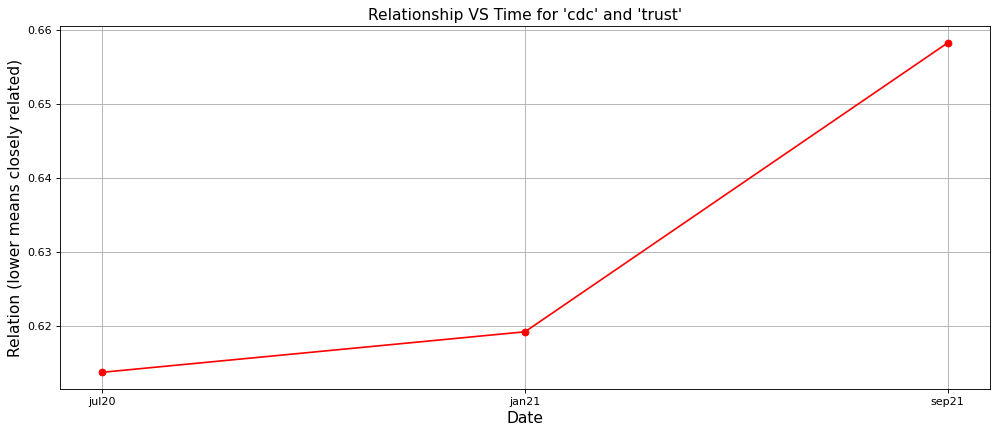

In [124]:
vis_relation("cdc", "trust")

[('report', 0.8046133518218994), ('israel', 0.7954927682876587), ("'coronavirus", 0.7885838747024536), ('data', 0.7870995402336121), ('fda', 0.7833999991416931), ('africa', 0.7788946032524109), ('study', 0.7748864889144897), ('official', 0.7681505680084229), ('iran', 0.7630996704101562), ('brazil', 0.7626031637191772), ('ceo', 0.7578532695770264), ('graham', 0.7527308464050293), ('lab', 0.7508912682533264), ('powered', 0.7476286292076111), ('yellen', 0.7457106709480286), ('west', 0.7412574291229248), ('b.c', 0.7411503195762634), ('outlined', 0.7407395839691162), ('whitty', 0.7399857640266418), ('efficacy', 0.7362862825393677)]


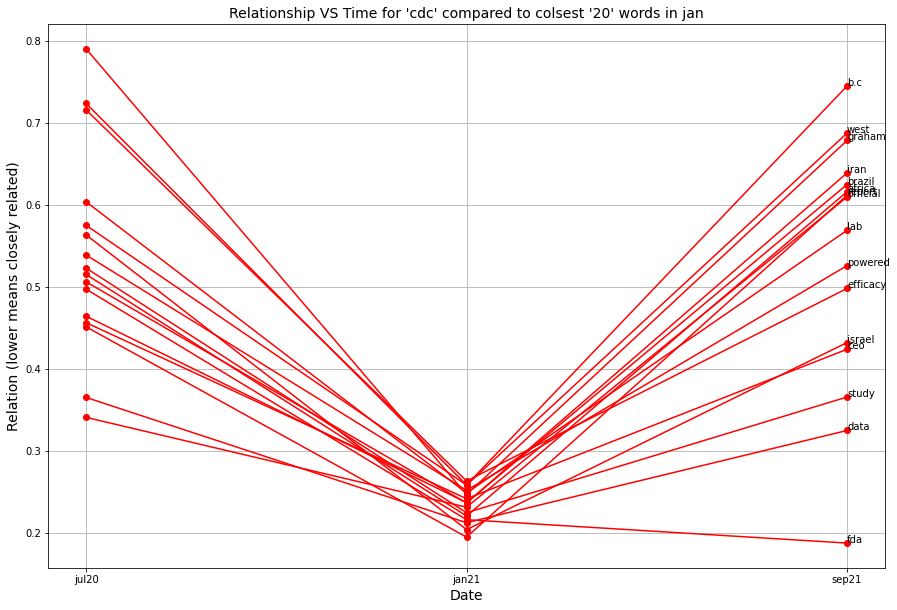

In [123]:
top_relation("cdc", "jan", 20)